In [7]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

In [53]:
# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Set batch size
batch_size = 10000

# Data loaders
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [54]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [55]:
# Create the autoencoder model and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)

# Define the loss function
criterion = nn.MSELoss()

# Set the device to GPU if available, otherwise use CPU
model.to(device)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [56]:
# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for images, _ in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2410.582776
Epoch: 2 	Training Loss: 2374.660820
Epoch: 3 	Training Loss: 2337.846284
Epoch: 4 	Training Loss: 2300.909733
Epoch: 5 	Training Loss: 2260.138715
Epoch: 6 	Training Loss: 2213.686953
Epoch: 7 	Training Loss: 2160.876791
Epoch: 8 	Training Loss: 2096.692696
Epoch: 9 	Training Loss: 2019.501328
Epoch: 10 	Training Loss: 1930.880571


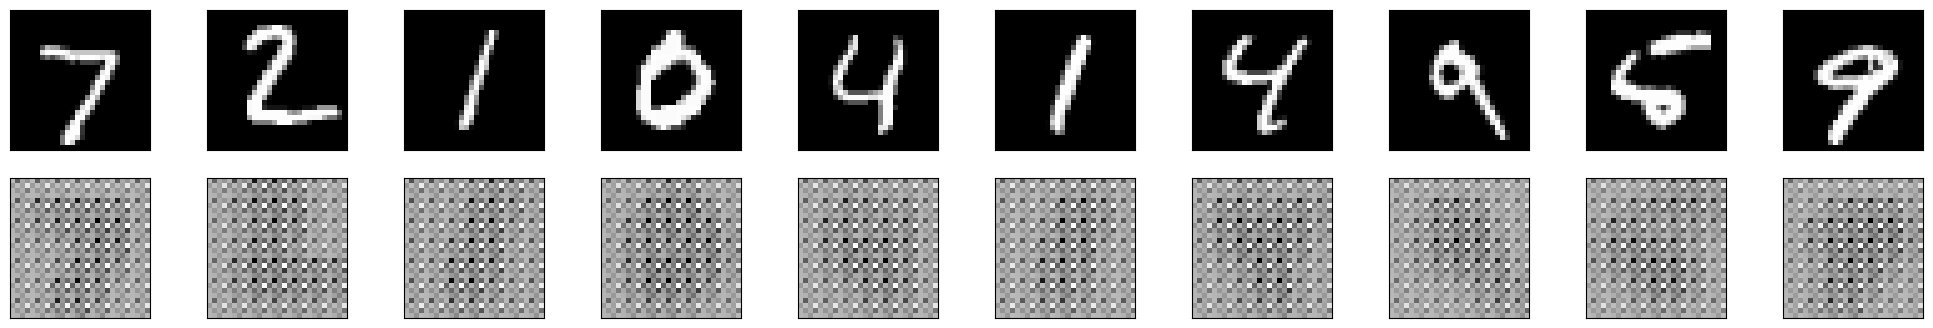

In [57]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)

# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)